In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#import xgboost as xgb
#import catboost as cb
%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('./train_s1/exam_score.csv')
df_test = pd.read_csv('./test_s1/submission_s1.csv')
df_test.rename(columns={'pred':'score'},inplace = True)
course_class = pd.read_csv('./train_s1/course.csv')
student = pd.read_csv('./train_s1/student.csv')
all_know = pd.read_csv('./train_s1/all_knowledge.csv')
df_all = df_train.append(df_test)
df_all = df_all.merge(course_class, on='course', how='left')
df_all = df_all.merge(student, on='student_id', how='left')

In [3]:
tmp1 = df_train.groupby(by=['student_id','course'], as_index=False)['score'].agg({'mean_score':np.mean, 'median_score':np.median, 'std_score':np.std,'max_score':np.max,'min_score':np.min})
tmp2 = df_train.groupby(by=['student_id'], as_index=False)['score'].agg({'s_mean_score':np.mean, 's_median_score':np.median, 's_std_score':np.std,'s_max_score':np.max,'min_score':np.min})

In [4]:
df_all=df_all.merge(tmp1, on=['student_id','course'], how='left')
df_all=df_all.merge(tmp2, on=['student_id'], how='left')

In [5]:
course1_exam = pd.read_csv('./train_s1/course1_exams.csv')
course2_exam = pd.read_csv('./train_s1/course2_exams.csv')
course3_exam = pd.read_csv('./train_s1/course3_exams.csv')
course4_exam = pd.read_csv('./train_s1/course4_exams.csv')
course5_exam = pd.read_csv('./train_s1/course5_exams.csv')
course6_exam = pd.read_csv('./train_s1/course6_exams.csv')
course7_exam = pd.read_csv('./train_s1/course7_exams.csv')
course8_exam = pd.read_csv('./train_s1/course8_exams.csv')
#col_c1 = [i for i in course1_exam.columns if i not in ['course','exam_id']]
tmp4=1
for i in [course1_exam,course2_exam,course3_exam,course4_exam,course5_exam,course6_exam,course7_exam,course8_exam]:
    name = i
    col_c1 = [i for i in name.columns if i not in ['course','exam_id']]
    name['course'] ='course'+str(tmp4)
    tmp2 =np.array(all_know.loc[all_know['course'] == ('course'+str(tmp4)),:]['complexity'])
    tmp = name[col_c1]
    tmp3 =np.dot(tmp.values,tmp2)
    name['hard'] = tmp3
    name['hard_inverse'] = name['hard'].apply(lambda x:1/(x+1e-10))
    tmp4 = tmp4+1

course_exam = course1_exam.append(course2_exam)
course_exam = course_exam.append(course3_exam)
course_exam = course_exam.append(course4_exam)
course_exam = course_exam.append(course5_exam)
course_exam = course_exam.append(course6_exam)
course_exam = course_exam.append(course7_exam)
course_exam = course_exam.append(course8_exam)
course_exam.fillna(0,inplace = True)

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
sub_course_exam = course_exam[['course','exam_id','hard','hard_inverse']]

In [7]:
df_all.shape

(73500, 16)

In [8]:
#df_all=df_all.merge(sub_course_exam, on=['exam_id','course'], how='left')
#将所有的特征都考虑进去，包括考试对应的考试点
df_all=df_all.merge(course_exam, on=['exam_id','course'], how='left')

In [9]:
#将课程对应的知识点的对应的段落和知识点加入特征
#df_all=df_all.merge(all_know,on=['course'],how='left')
df_all.shape
#特征选择



(73500, 386)

In [18]:
for i in ['course','course_class','exam_id','student_id']:
    lbl = LabelEncoder()
    #all_data[i+"_count"] = all_data.groupby([i])[i].transform('count')
    #all_data[i+"_rank"] = all_data[i+"_count"].rank(method='min')
    df_all[i] = lbl.fit_transform(df_all[i].astype(str))
#将数据集保存
df_all.to_csv('df_all.csv')
#添加特征工程
df_train = df_all[:65500]
#lr=LinearRegression()
#rfe=RFE(lr,n_features_to_select=2)#选择剔除1个
target=[i for i in df_train.columns if i not in ['score']]
print(target)
X=df_train[target]
print(X.shape)
Y=df_train['score']
#names=X.columns
#print(names)
#rfe.fit(X,Y)
#print("features sorted by their rank:")
#print(rfe)
#futures=sorted(zip(map(lambda x:round(x,4), rfe.ranking_),names))#特征选择出的特征
#print(futures)
#print(len(futures))
#将训练集和测试集的特征换成新的特征
df_test = df_all[65500:].reset_index(drop=True)
df_test=df_test[target]
X_train=X
#X_train=X.drop(['hard_inverse','mean_score'],axis=1)
#df_test=df_test.drop(['hard_inverse','mean_score'],axis=1)


['student_id', 'course', 'exam_id', 'course_class', 'gender', 'mean_score', 'median_score', 'std_score', 'max_score', 'min_score_x', 's_mean_score', 's_median_score', 's_std_score', 's_max_score', 'min_score_y', 'K:0', 'K:1', 'K:10', 'K:100', 'K:101', 'K:102', 'K:103', 'K:104', 'K:105', 'K:106', 'K:107', 'K:108', 'K:109', 'K:11', 'K:110', 'K:111', 'K:112', 'K:113', 'K:114', 'K:115', 'K:116', 'K:117', 'K:118', 'K:119', 'K:12', 'K:120', 'K:121', 'K:122', 'K:123', 'K:124', 'K:125', 'K:126', 'K:127', 'K:128', 'K:129', 'K:13', 'K:130', 'K:131', 'K:132', 'K:133', 'K:134', 'K:135', 'K:136', 'K:137', 'K:138', 'K:139', 'K:14', 'K:140', 'K:141', 'K:142', 'K:143', 'K:144', 'K:145', 'K:146', 'K:147', 'K:148', 'K:149', 'K:15', 'K:150', 'K:151', 'K:152', 'K:153', 'K:154', 'K:155', 'K:156', 'K:157', 'K:158', 'K:159', 'K:16', 'K:160', 'K:161', 'K:162', 'K:163', 'K:164', 'K:165', 'K:166', 'K:167', 'K:168', 'K:169', 'K:17', 'K:170', 'K:171', 'K:172', 'K:173', 'K:174', 'K:175', 'K:176', 'K:177', 'K:178',

In [20]:
y=Y
test_y = np.zeros(len(df_test))
random_seed = 2018#生成随机数
cv_model = []
cv_score = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    print(index)#
    train_x, val_x, train_y, val_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators': 10000,
        #'metric': 'mae',
        'learning_rate': 0.01,
        'min_child_samples': 46,
        'min_child_weight': 0.1,
        'subsample_freq': 1,
        'num_leaves': 40,
        'max_depth': 7,
        'subsample': 0.42,
        'colsample_bytree': 0.48,
        'reg_alpha': 0.15,
        'reg_lambda': 5,
        'verbose': -1,
        'seed': 4590
    }
    lgb = LGBMRegressor(**lgb_params)

# 'verbose': -1,
    lgb.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (val_x, val_y)],
        eval_names=['train', 'val'],
        eval_metric='rmse',
        #eval_metric = evaluate_macroF1_lgb, 
        early_stopping_rounds=20,#早停止
        verbose=10
    )
    cv_model.append(lgb)#一共5个模型
    lgb.n_estimators = lgb.best_iteration_#森林中树的数量，状态的学习器
    val_y_pred = lgb.predict(val_x)
    cv_score.append( np.sqrt(mean_squared_error(val_y,val_y_pred)))
    test_y += lgb.predict(df_test)/5
print("CV score: ",np.mean(cv_score))

c:\users\dell\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0
Training until validation scores don't improve for 20 rounds.
[10]	train's l2: 89.1213	train's rmse: 9.44041	val's l2: 89.5318	val's rmse: 9.46213
[20]	train's l2: 79.4922	train's rmse: 8.91584	val's l2: 79.9278	val's rmse: 8.94024
[30]	train's l2: 71.5217	train's rmse: 8.45705	val's l2: 71.9907	val's rmse: 8.48473
[40]	train's l2: 64.9193	train's rmse: 8.05725	val's l2: 65.4139	val's rmse: 8.08789
[50]	train's l2: 59.4573	train's rmse: 7.71085	val's l2: 59.9641	val's rmse: 7.74365
[60]	train's l2: 55.0614	train's rmse: 7.42034	val's l2: 55.5743	val's rmse: 7.45482
[70]	train's l2: 51.4084	train's rmse: 7.16997	val's l2: 51.9373	val's rmse: 7.20675
[80]	train's l2: 48.1792	train's rmse: 6.94113	val's l2: 48.7263	val's rmse: 6.98042
[90]	train's l2: 45.4755	train's rmse: 6.74355	val's l2: 46.031	val's rmse: 6.78461
[100]	train's l2: 43.191	train's rmse: 6.57198	val's l2: 43.7476	val's rmse: 6.61419
[110]	train's l2: 41.3322	train's rmse: 6.42902	val's l2: 41.9024	val's rmse: 6.4732
[1

[320]	train's l2: 30.8834	train's rmse: 5.55728	val's l2: 32.8453	val's rmse: 5.73108
[330]	train's l2: 30.7779	train's rmse: 5.54778	val's l2: 32.7829	val's rmse: 5.72563
[340]	train's l2: 30.692	train's rmse: 5.54004	val's l2: 32.7382	val's rmse: 5.72173
[350]	train's l2: 30.6104	train's rmse: 5.53267	val's l2: 32.6877	val's rmse: 5.71731
[360]	train's l2: 30.5335	train's rmse: 5.52571	val's l2: 32.6509	val's rmse: 5.71409
[370]	train's l2: 30.4602	train's rmse: 5.51907	val's l2: 32.6045	val's rmse: 5.71003
[380]	train's l2: 30.3943	train's rmse: 5.51311	val's l2: 32.572	val's rmse: 5.70719
[390]	train's l2: 30.3288	train's rmse: 5.50716	val's l2: 32.5374	val's rmse: 5.70416
[400]	train's l2: 30.2767	train's rmse: 5.50243	val's l2: 32.5152	val's rmse: 5.70221
[410]	train's l2: 30.2297	train's rmse: 5.49816	val's l2: 32.5008	val's rmse: 5.70095
[420]	train's l2: 30.1711	train's rmse: 5.49283	val's l2: 32.486	val's rmse: 5.69965
[430]	train's l2: 30.122	train's rmse: 5.48835	val's l2: 

[60]	train's l2: 55.0923	train's rmse: 7.42242	val's l2: 55.3503	val's rmse: 7.43978
[70]	train's l2: 51.4161	train's rmse: 7.17051	val's l2: 51.7352	val's rmse: 7.19272
[80]	train's l2: 48.1647	train's rmse: 6.94008	val's l2: 48.5464	val's rmse: 6.96753
[90]	train's l2: 45.4765	train's rmse: 6.74363	val's l2: 45.8995	val's rmse: 6.77492
[100]	train's l2: 43.2031	train's rmse: 6.57291	val's l2: 43.6752	val's rmse: 6.60872
[110]	train's l2: 41.3351	train's rmse: 6.42924	val's l2: 41.8625	val's rmse: 6.47012
[120]	train's l2: 39.7927	train's rmse: 6.30814	val's l2: 40.38	val's rmse: 6.35453
[130]	train's l2: 38.4925	train's rmse: 6.20423	val's l2: 39.1207	val's rmse: 6.25465
[140]	train's l2: 37.4096	train's rmse: 6.11634	val's l2: 38.1011	val's rmse: 6.17261
[150]	train's l2: 36.4854	train's rmse: 6.04032	val's l2: 37.2137	val's rmse: 6.1003
[160]	train's l2: 35.6724	train's rmse: 5.97264	val's l2: 36.4463	val's rmse: 6.03708
[170]	train's l2: 34.9958	train's rmse: 5.91572	val's l2: 35.

[270]	train's l2: 31.6104	train's rmse: 5.62232	val's l2: 32.814	val's rmse: 5.72835
[280]	train's l2: 31.4488	train's rmse: 5.60793	val's l2: 32.6843	val's rmse: 5.71702
[290]	train's l2: 31.3173	train's rmse: 5.59619	val's l2: 32.5832	val's rmse: 5.70817
[300]	train's l2: 31.1943	train's rmse: 5.58519	val's l2: 32.5041	val's rmse: 5.70123
[310]	train's l2: 31.0718	train's rmse: 5.57421	val's l2: 32.4201	val's rmse: 5.69386
[320]	train's l2: 30.9642	train's rmse: 5.56455	val's l2: 32.3512	val's rmse: 5.68781
[330]	train's l2: 30.8721	train's rmse: 5.55627	val's l2: 32.2857	val's rmse: 5.68205
[340]	train's l2: 30.7837	train's rmse: 5.54831	val's l2: 32.2335	val's rmse: 5.67746
[350]	train's l2: 30.703	train's rmse: 5.54103	val's l2: 32.1882	val's rmse: 5.67346
[360]	train's l2: 30.6198	train's rmse: 5.53352	val's l2: 32.1529	val's rmse: 5.67036
[370]	train's l2: 30.5524	train's rmse: 5.52743	val's l2: 32.1048	val's rmse: 5.66611
[380]	train's l2: 30.4891	train's rmse: 5.52169	val's l2

In [21]:
test_y

array([85.0289879 , 79.36967795, 82.86448104, ..., 75.86628594,
       71.36030588, 70.48338447])

In [22]:
sub_test = pd.read_csv('./test_s1/submission_s1.csv')

In [23]:
sub_test['pred'] = test_y

In [24]:
sub_test

,student_id,course,exam_id,pred
0,230748,course1,m31I6cTD,85.028988
1,186851,course1,m31I6cTD,79.369678
2,478370,course1,m31I6cTD,82.864481
3,692328,course1,m31I6cTD,83.664346
4,509128,course1,m31I6cTD,80.936802
5,604234,course1,m31I6cTD,97.158036
6,992922,course1,m31I6cTD,79.579367
7,488841,course1,m31I6cTD,92.693437
8,831322,course1,m31I6cTD,83.973556
9,940245,course1,m31I6cTD,78.673287


In [25]:
sub_test.to_csv('./submisson.csv',index=None)

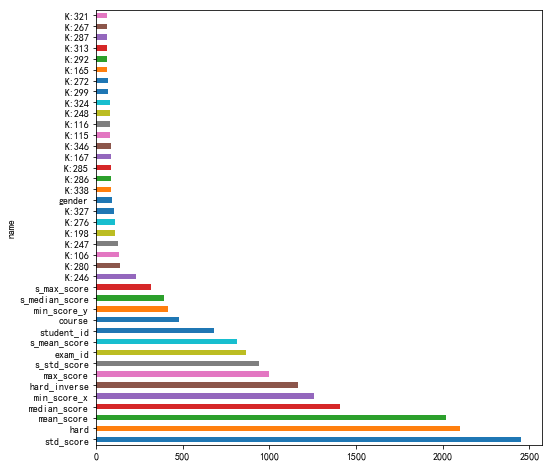

In [27]:
fi = []
for i in cv_model:
    tmp = {
        'name' : target,
        'score' : i.feature_importances_
    }
    fi.append(pd.DataFrame(tmp))
    
fi = pd.concat(fi)
fig = plt.figure(figsize=(8,8))
fi.groupby(['name'])['score'].agg('mean').sort_values(ascending=False).head(40).plot.barh()